In [1]:
library(igraph)
# install.packages("gsubfn")
library(gsubfn) #allows unpacking multiple return values from functions without using a dummy variable (but needs a fresh R session to work, intitially)

Warning message:
"package 'igraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'gsubfn' was built under R version 3.6.3"Loading required package: proto
Warning message:
"package 'proto' was built under R version 3.6.3"

In [2]:
#install.packages("resample")
library('resample')


Attaching package: 'resample'

The following object is masked from 'package:gsubfn':

    cat0



In [3]:
library('Matrix')
library('pracma')

Warning message:
"package 'pracma' was built under R version 3.6.3"
Attaching package: 'pracma'

The following objects are masked from 'package:Matrix':

    expm, lu, tril, triu



In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
logspace <- function( d1, d2, n) exp(log(10)*seq(d1, d2, length.out=n))

# Part 2

## Q3

In [6]:
create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    if(!is_connected(g)){
        print("Not connected")
    }
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}

In [7]:
random_walk_custom = function (g, num_steps, start_node, transition_matrix = NULL, teleportation=0.0, teleport_visit_mode="equal"){
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    vert_seq = array(NA, length(num_steps))
    
    switch(teleport_visit_mode, 
    "equal"={
        visit_probs=array(1/vcount(g), vcount(g))
    },
    "pg"={
        pg_ranks=page_rank(g, directed=T)$vector
        visit_probs=pg_ranks/sum(pg_ranks)   
    },
    "pg_median"={
        pg_ranks=page_rank(g, directed=T)$vector
        df = data.frame("idx"=1:vcount(g), "val"=pg_ranks)
        df=df[order(df$val),]
        visit_probs=array(0, vcount(g))
        mid=vcount(g) %/% 2
        visit_probs[df$idx[mid:mid+1]]=0.5
    },
    {
       visit_probs=array(1/vcount(g), vcount(g))
    }
    )
    
    
    
    
    for(i in 1:num_steps){
        #fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
        if(runif(1)<teleportation){
            v = sample(1:vcount(g), 1, prob = visit_probs)   
        }
        else{
            PMF = transition_matrix[v, ]
            v = sample(1:vcount(g), 1, prob = PMF)   
        }     
        vert_seq[i] = v
    }
    
    return(vert_seq)
}

In [8]:
perform_random_walk_custom = function(g, steps, iters, teleportation=0.0, teleport_visit_mode="equal"){
    n_node_visits=array(0, vcount(g))
    n_steady_state = ceiling(log(vcount(g)))
    for(i in 1:iters){
        start_vert = sample(1:vcount(g), 1)
        vert_seq = random_walk_custom(g, steps, start_vert, teleportation=teleportation, teleport_visit_mode=teleport_visit_mode)
        for (j in 1:length(vert_seq)) {
            if (j > n_steady_state) {
                n_node_visits[vert_seq[j]] = n_node_visits[vert_seq[j]] + 1
            }
        }
    }
    return (n_node_visits / ((steps-n_steady_state) * iters))
}

#### (a)

In [9]:
g1 <- sample_pa(n=1000, m=4, directed=T)
g2 <- sample_pa(n=1000, m=4, directed=T)

In [10]:
g2p <- permute(g2, sample(vcount(g2)))

In [11]:
g11 = add_edges(g1, c(t(as_edgelist(g2p))))

In [12]:
print(ecount(g11))

[1] 7980


In [13]:
set.seed(1)

In [14]:
iters=100
steps=1000

In [15]:
node_visits_probs=perform_random_walk_custom(g11, steps, iters)

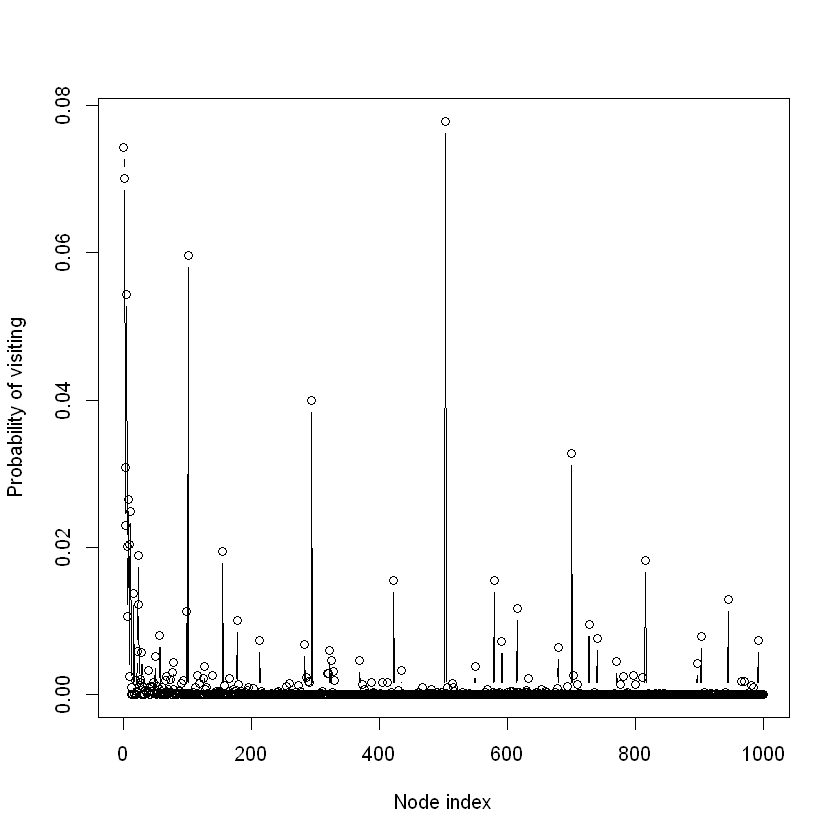

In [21]:
plot(node_visits_probs, type="b", xlab='Node index', ylab='Probability of visiting')

In [19]:
png(sprintf("plots/p1q2_3_a_1.png"))
plot(node_visits_probs, type="b", xlab='Node index', ylab='Probability of visiting')
dev.off()

png 
  2

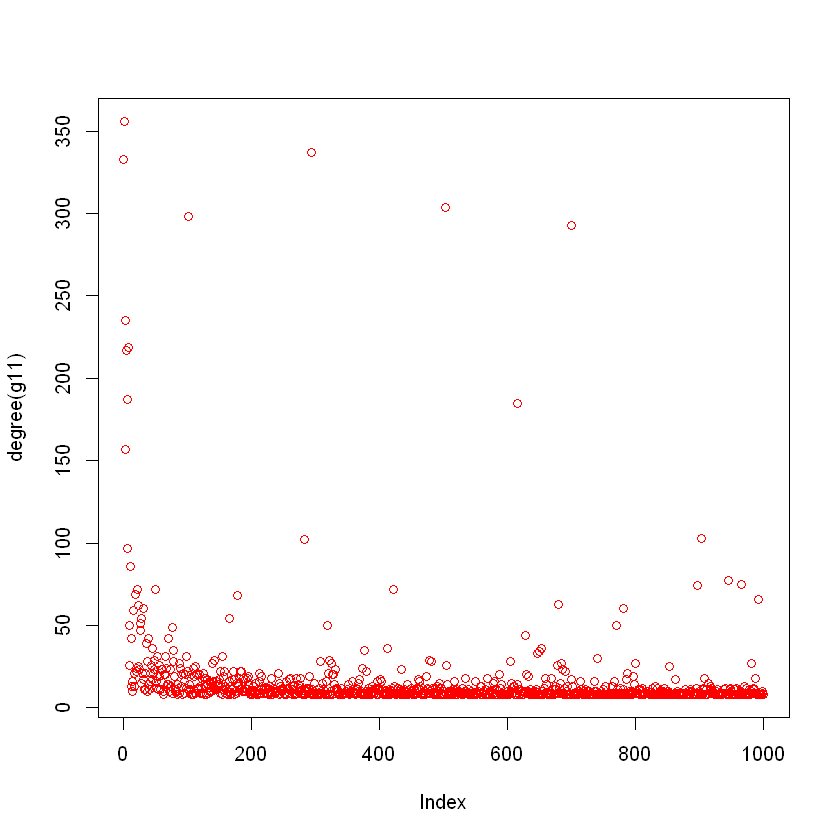

In [22]:
plot(degree(g11),col="red")

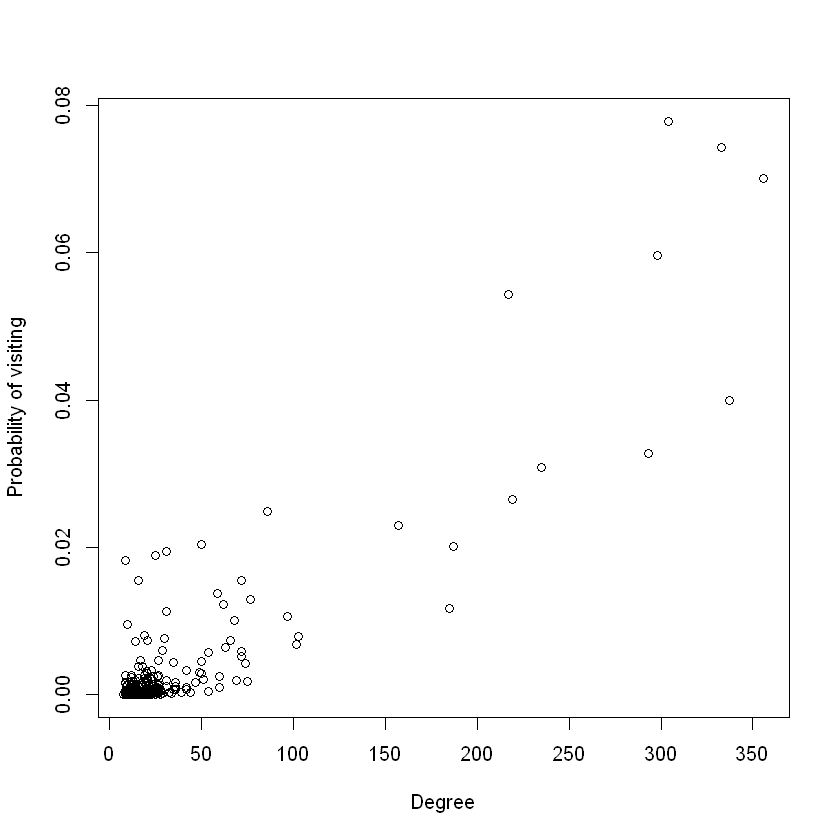

In [24]:
plot(degree(g11), node_visits_probs, xlab='Degree', ylab='Probability of visiting')

In [50]:
fit_line = function(x, y, log=FALSE){
    if(log){
        slope <- getElement(lm(log(y) ~ log(x))$coefficients[2], "log(x)")
        intercept <- getElement(lm(log(y) ~ log(x))$coefficients[1], "(Intercept)")
    }
    else{
        slope <- getElement(lm(y ~ x)$coefficients[2], "x")
        intercept <- getElement(lm(y ~ x)$coefficients[1], "(Intercept)")
    }
    return (list(slope, intercept))
}

[1] 0.0001713408
[1] 0.9045546


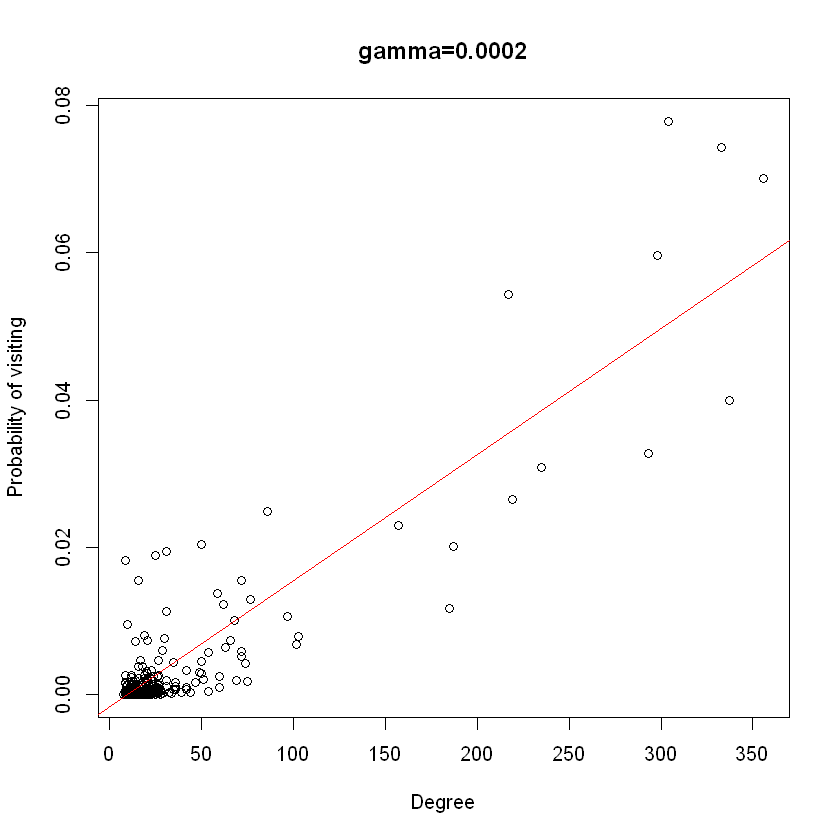

In [52]:
list[slope, d] <- fit_line(degree(g11), node_visits_probs)
print(slope)
plot(degree(g11), node_visits_probs, xlab='Degree', ylab='Probability of visiting',main=sprintf("gamma=%.4f", slope))
abline(lm(node_visits_probs ~ degree(g11)), col="red")
print(cor(degree(g11), node_visits_probs))

In [26]:
png(sprintf("plots/p1q2_3_a_2.png"))
plot(degree(g11), node_visits_probs, xlab='Degree', ylab='Probability of visiting')
dev.off()

png 
  2

#### (b)

In [30]:
iters=100
steps=1000
alpha=0.15

In [31]:
node_visits_probs_equal=perform_random_walk_custom(g11, steps, iters, teleportation=alpha, teleport_visit_mode="equal")

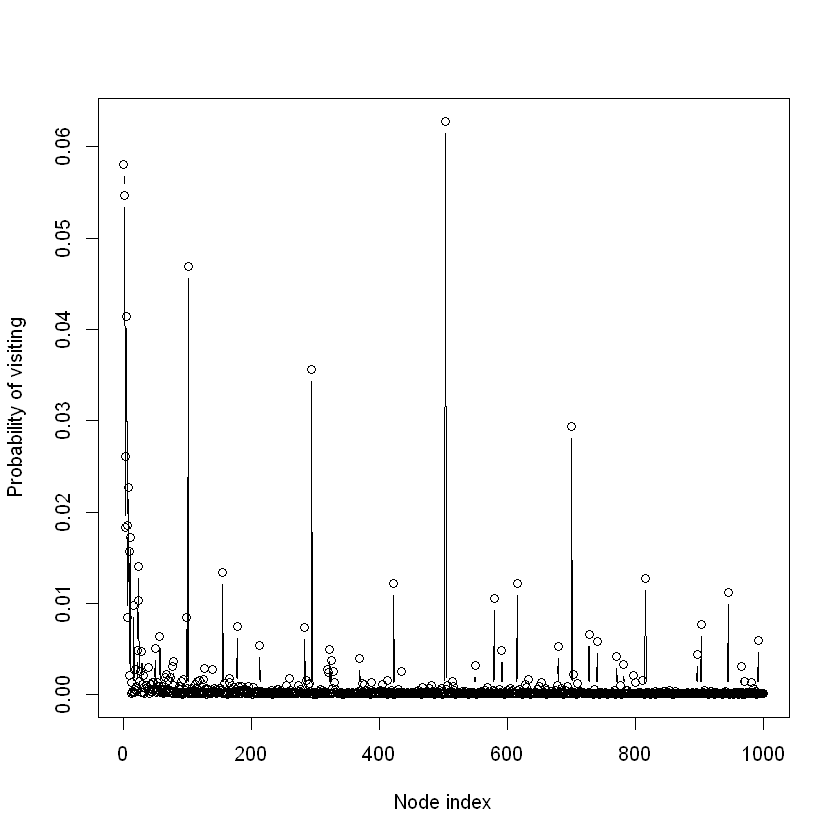

In [32]:
plot(node_visits_probs_equal, type="b", xlab='Node index', ylab='Probability of visiting')

In [33]:
png(sprintf("plots/p1q2_3_b_1.png"))
plot(node_visits_probs_equal, type="b", xlab='Node index', ylab='Probability of visiting')
dev.off()

png 
  2

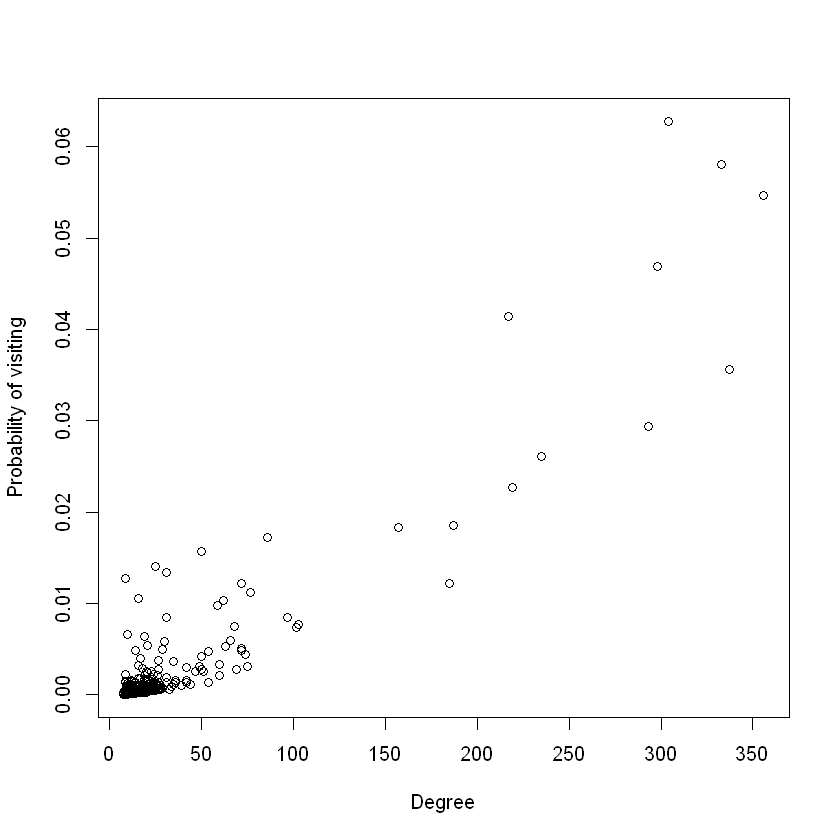

In [35]:
plot(degree(g11), node_visits_probs_equal, xlab='Degree', ylab='Probability of visiting')

[1] 0.0001397091
[1] 0.9288324


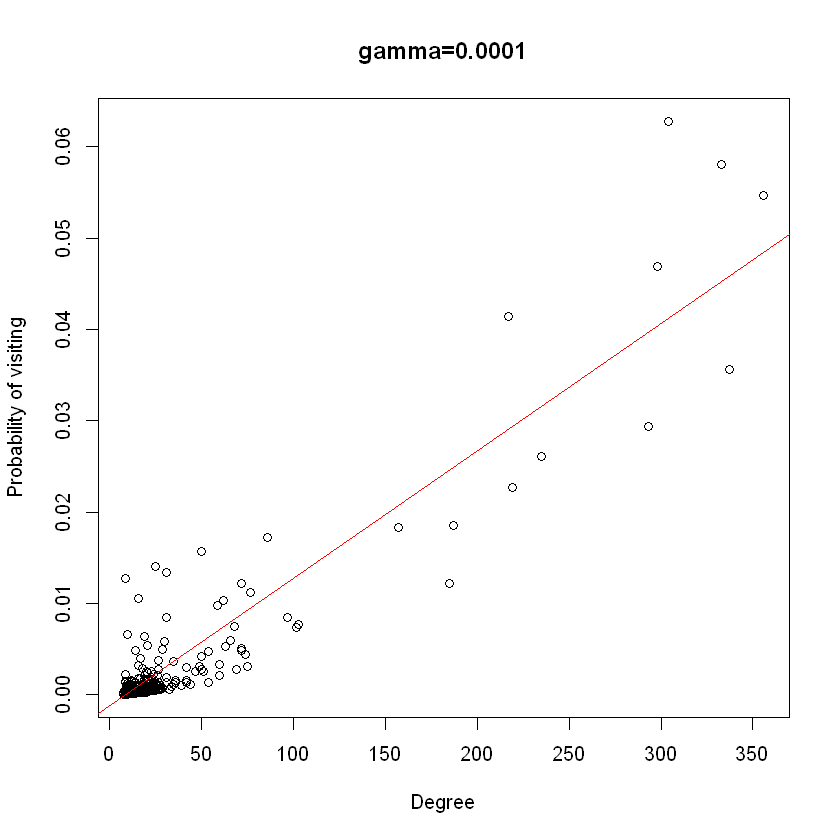

In [53]:
list[slope_equal, d] <- fit_line(degree(g11), node_visits_probs_equal)
print(slope_equal)
plot(degree(g11), node_visits_probs_equal, xlab='Degree', ylab='Probability of visiting',main=sprintf("gamma=%.4f", slope_equal))
abline(lm(node_visits_probs_equal ~ degree(g11)), col="red")
print(cor(degree(g11), node_visits_probs_equal))

In [36]:
png(sprintf("plots/p1q2_3_b_2.png"))
plot(degree(g11), node_visits_probs_equal, xlab='Degree', ylab='Probability of visiting')
dev.off()

png 
  2

## Q4

#### (a)

In [37]:
node_visits_probs_pg=perform_random_walk_custom(g11, steps, iters, teleportation=alpha, teleport_visit_mode="pg")

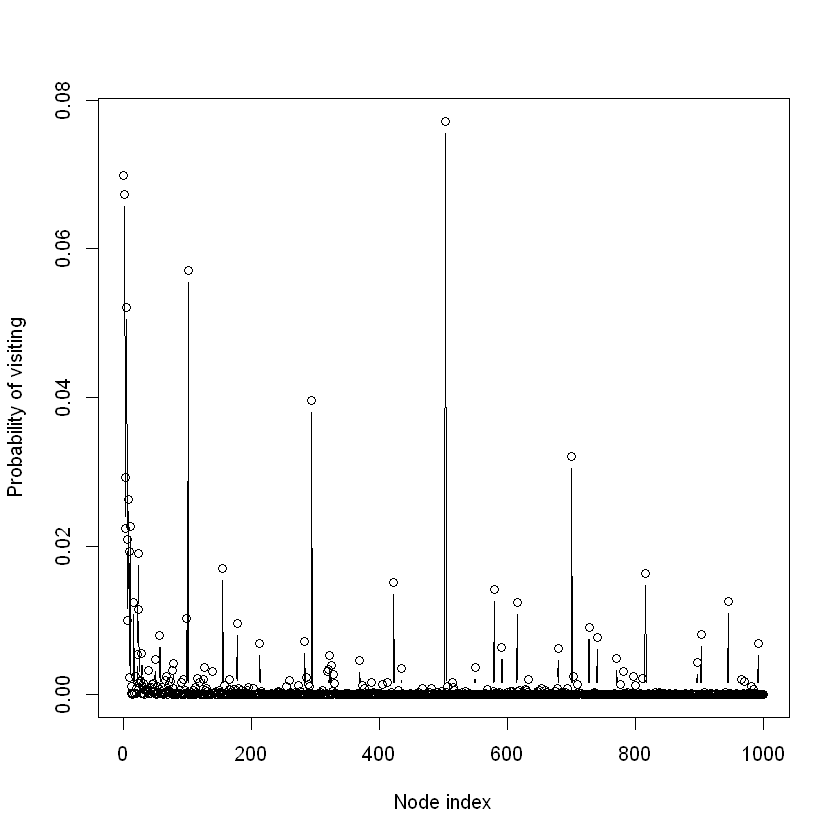

In [38]:
plot(node_visits_probs_pg, type="b", xlab='Node index', ylab='Probability of visiting')

In [39]:
png(sprintf("plots/p1q2_4_a_1.png"))
plot(node_visits_probs_pg, type="b", xlab='Node index', ylab='Probability of visiting')
dev.off()

png 
  2

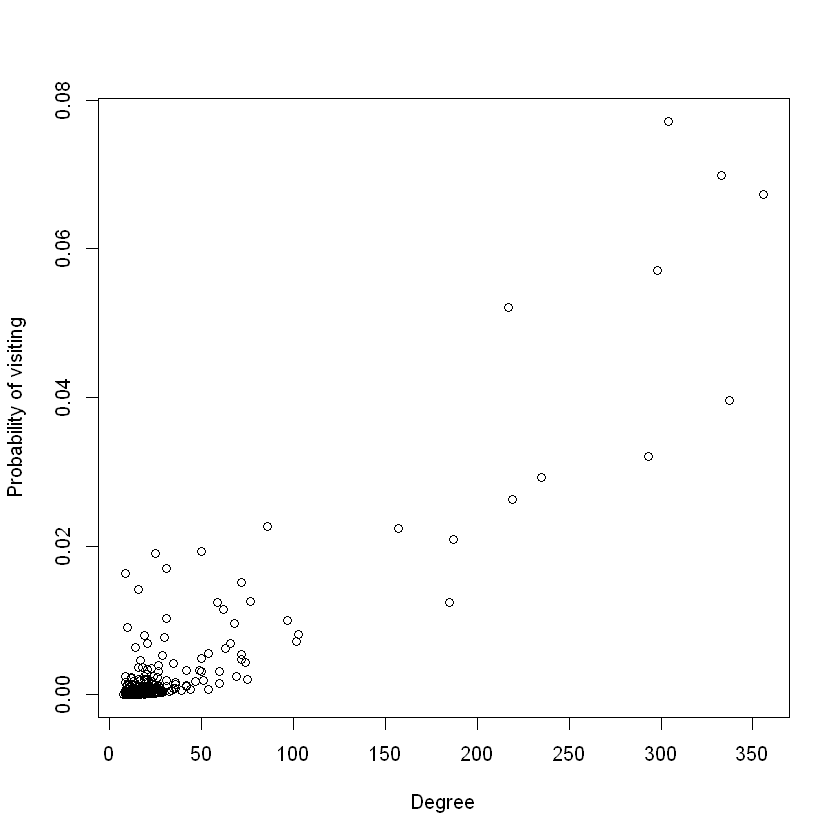

In [40]:
plot(degree(g11), node_visits_probs_pg, xlab='Degree', ylab='Probability of visiting')

[1] 0.0001660616
[1] 0.9107512


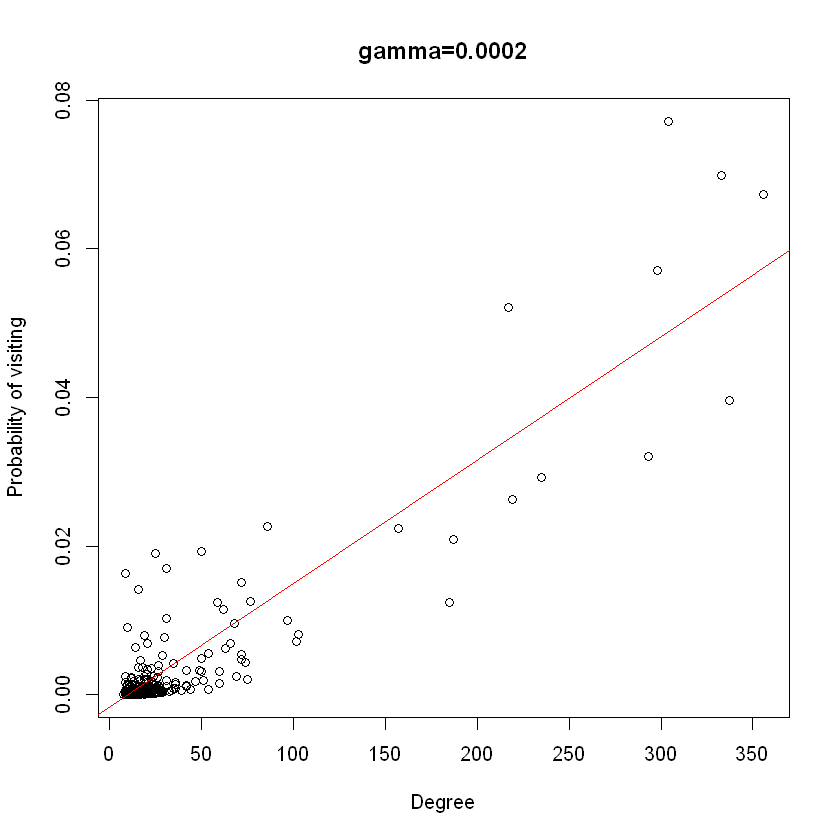

In [54]:
list[slope_pg, d] <- fit_line(degree(g11), node_visits_probs_pg)
print(slope_pg)
plot(degree(g11), node_visits_probs_pg, xlab='Degree', ylab='Probability of visiting',main=sprintf("gamma=%.4f", slope_pg))
abline(lm(node_visits_probs_pg ~ degree(g11)), col="red")
print(cor(degree(g11), node_visits_probs_pg))

In [41]:
png(sprintf("plots/p1q2_4_a_2.png"))
plot(degree(g11), node_visits_probs_pg, xlab='Degree', ylab='Probability of visiting')
dev.off()

png 
  2

#### (b)

In [42]:
n_node_visits_pg_median=perform_random_walk_custom(g11, steps, iters, teleportation=alpha, teleport_visit_mode="pg_median")

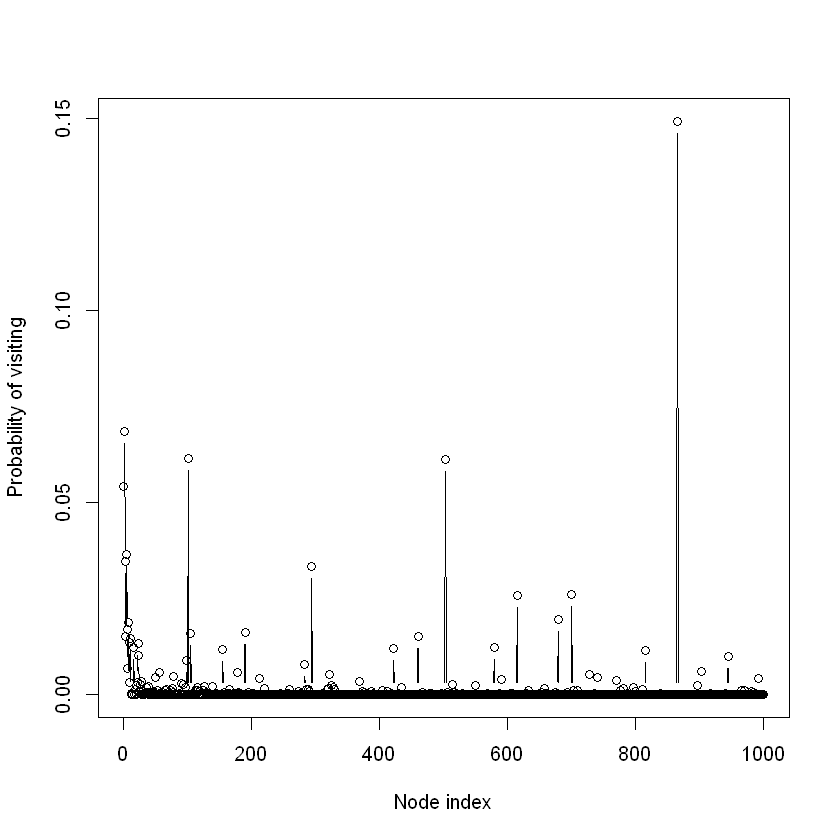

In [43]:
plot(n_node_visits_pg_median, type="b", xlab='Node index', ylab='Probability of visiting')

In [44]:
png(sprintf("plots/p1q2_4_b_1.png"))
plot(n_node_visits_pg_median, type="b", xlab='Node index', ylab='Probability of visiting')
dev.off()

png 
  2

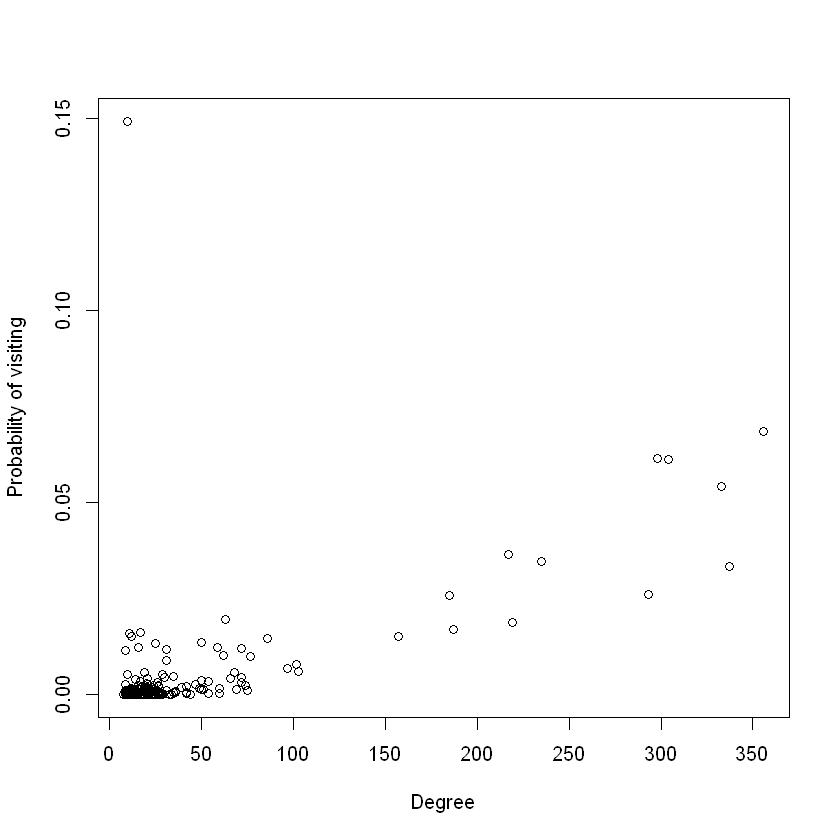

In [45]:
plot(degree(g11), n_node_visits_pg_median, xlab='Degree', ylab='Probability of visiting')

[1] 0.0001461807
[1] 0.6448008


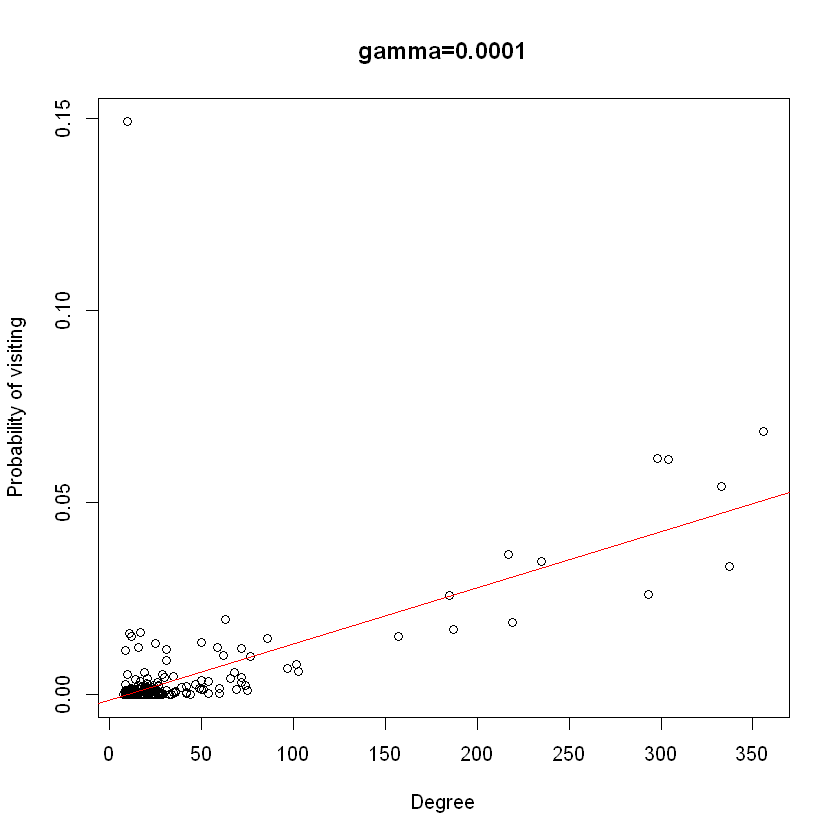

In [55]:
list[slope_pg_median, d] <- fit_line(degree(g11), n_node_visits_pg_median)
print(slope_pg_median)
plot(degree(g11), n_node_visits_pg_median, xlab='Degree', ylab='Probability of visiting',main=sprintf("gamma=%.4f", slope_pg_median))
abline(lm(n_node_visits_pg_median ~ degree(g11)), col="red")
print(cor(degree(g11), n_node_visits_pg_median))

In [46]:
png(sprintf("plots/p1q2_4_b_2.png"))
plot(degree(g11), n_node_visits_pg_median, xlab='Degree', ylab='Probability of visiting')
dev.off()

png 
  2

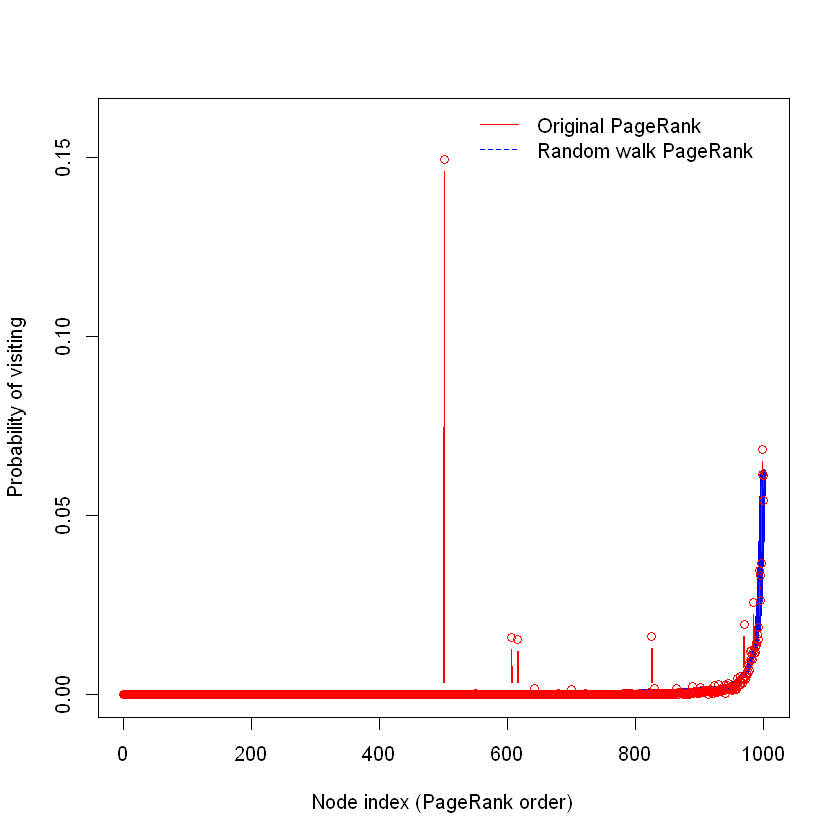

In [77]:
pageranks = page_rank(g11)$vector
plot(sort(pageranks), col="blue", type='l',lwd=5, ylim=c(0,0.16), xlab='Node index (PageRank order)', ylab='Probability of visiting')
lines(n_node_visits_pg_median[order(pageranks)], col="red", type='b')
legend("topright", legend = c("Original PageRank", "Random walk PageRank"), col = c("red", "blue"), bty = "n", lty=1:2, cex=1)

In [78]:
png(sprintf("plots/p1q2_4_b_3.png"))
plot(sort(pageranks), col="blue", type='l',lwd=5, ylim=c(0,0.16), xlab='Node index (PageRank order)', ylab='Probability of visiting')
lines(n_node_visits_pg_median[order(pageranks)], col="red", type='b')
legend("topright", legend = c("Original PageRank", "Random walk PageRank"), col = c("red", "blue"), bty = "n", lty=1:2, cex=1)
dev.off()

png 
  2